In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
tf.__version__

'2.10.0'

In [3]:
homer_bart_data_2 = 'dados\Datasets\homer_bart_2.zip'
with zipfile.ZipFile(homer_bart_data_2, 'r') as zip_ref:
    zip_ref.extractall('./homer_bart_2')
    zip_ref.close()


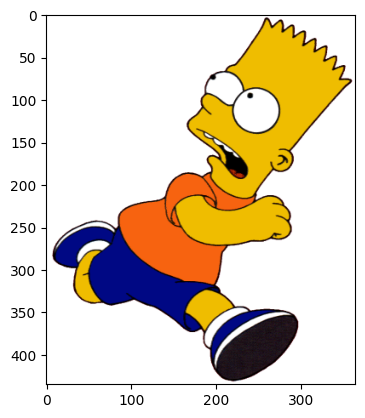

In [4]:
#tf.keras.preprocessing.image.load_img('./homer_bart_2/training_set/bart/bart29.bmp')
path = Path('./homer_bart_2/homer_bart_2/training_set/bart/',  'bart100.bmp')
if path.is_file():
    img = tf.keras.preprocessing.image.load_img(path)
    plt.imshow(img)




# BASES DE TREINAMENTO E TEST


### Criando o modelo já com um pre-modelo que já trata os dados


In [5]:
#criando um pre-modelo para já tratar os dados de entrada (recomendado atualemnte no tf para imgs)
#assim o tratamento de dados já fica "embutido" no modelo
pre_model = Sequential(name='pre_model')
pre_model.add(tf.keras.layers.Input(shape=(64, 64, 3)))
pre_model.add(tf.keras.layers.Resizing(64, 64))
pre_model.add(tf.keras.layers.Rescaling(1./255))
pre_model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
pre_model.add(tf.keras.layers.RandomZoom(0.2, fill_mode='reflect'))
pre_model.add(tf.keras.layers.RandomRotation(0.2))

pre_model.summary()

#camadas random* são usadas para data augmentation (aumentar a variabilidade dos dados de treino)
#essas camadas só devem ser ativas no treinamento (training=True)
#para validação e teste, usar training=False


Model: "pre_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_______________________________________________________________

In [6]:
#validando o pre-modelo
img_pre_model_test = cv2.imread('./homer_bart_2/homer_bart_2/training_set/bart/bart100.bmp', cv2.COLOR_BGR2RGB)
img_pre_model_test = cv2.resize(img_pre_model_test, (64, 64))
img_pre_model_test = np.expand_dims(img_pre_model_test, axis=0)  #adiciona dimensão de batch
out = pre_model(img_pre_model_test, training=True)
print(img_pre_model_test.shape, out.shape)


(1, 64, 64, 3) (1, 64, 64, 3)


### Carregando os dados de test e train com keras

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./homer_bart_2/homer_bart_2/training_set/",
    image_size=(64, 64),
    label_mode='categorical',
    class_names=['homer', 'bart'], #forçando a ordem dos rótulos 0 = homer, 1 = bart
    batch_size=32,
    shuffle=True
)



train_ds_pre_processado = train_ds.map(lambda x, y: (pre_model(x, training=True), y))  

test_ds = tf.keras.utils.image_dataset_from_directory(
    "./homer_bart_2/homer_bart_2/test_set/",
    image_size=(64, 64),
    label_mode='categorical',
    class_names=['homer', 'bart'], #forçando a ordem dos rótulos 0 = homer, 1 = bart
    batch_size=32,
    shuffle=False
)
test_ds_pre_processado = test_ds.map(lambda x, y: (pre_model(x, training=False), y))




Found 215 files belonging to 2 classes.
Found 54 files belonging to 2 classes.


In [ ]:
#valores dos dados de test uma lista com  tuplas contendo o conteúdo e o rótulo

first_img = train_ds.take(2) #método get retorna um batch onde contém 32 (valor do batch) imagens e seus respectivos rótulos 

for img, label in first_img:
    print(img.shape)
    print(label.shape)


(32, 64, 64, 3)
(32, 2)
(32, 64, 64, 3)
(32, 2)


In [9]:
test_rotulos = test_ds.class_names
test_rotulos






['homer', 'bart']

## Criando o modelo principal 

In [10]:
#criando o modelo CNN completo
model = Sequential(name='cnn_model')
model.add(pre_model)

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense( units= 3137 , activation='relu'))
#ver o calculo dos neurônios na proxima célula

model.add(Dense( units=2 , activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pre_model (Sequential)      (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        92

In [11]:
#pegar o valor da ultima matriz da cnn (maxpooling2d) 
# esses valores são os dados que irão para a entrada do Modelo denso
#Então precisamos calcular esse valor para definir a quantidade de neurônios na camada densa
val_total_last_matriz = 14 * 14 * 32 # qtde de info da ultima matriz 30x30 com 64 filtros
neuronios_dense = (val_total_last_matriz + 2) / 2 # qtde de info + qtde_class / qtde_class
neuronios_dense

3137.0

In [12]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)  


Epoch 1/10
7/7 [==============================] - 13s 267ms/step - loss: 0.9525 - accuracy: 0.5814 - val_loss: 0.6849 - val_accuracy: 0.5185
Epoch 2/10
7/7 [==============================] - 1s 197ms/step - loss: 0.6384 - accuracy: 0.6140 - val_loss: 0.7414 - val_accuracy: 0.5185
Epoch 3/10
7/7 [==============================] - 2s 227ms/step - loss: 0.5861 - accuracy: 0.7163 - val_loss: 0.8654 - val_accuracy: 0.5556
Epoch 4/10
7/7 [==============================] - 2s 251ms/step - loss: 0.5388 - accuracy: 0.7395 - val_loss: 1.0201 - val_accuracy: 0.5556
Epoch 5/10
7/7 [==============================] - 2s 248ms/step - loss: 0.5565 - accuracy: 0.7535 - val_loss: 0.7181 - val_accuracy: 0.7037
Epoch 6/10
7/7 [==============================] - 2s 249ms/step - loss: 0.5329 - accuracy: 0.7674 - val_loss: 0.7311 - val_accuracy: 0.6852
Epoch 7/10
7/7 [==============================] - 2s 247ms/step - loss: 0.5030 - accuracy: 0.7907 - val_loss: 0.8749 - val_accuracy: 0.6667
Epoch 8/10
7/7 [===

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy no teste: {test_acc:.4f}")

2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - accuracy: 0.6667
Accuracy no teste: 0.6667


### Rotulos com a classficicao categorical (um neuronio para cada classe)

In [14]:
rotulos = [y for _, y in test_ds]
rotulos

#como a classificao é categorical, cada rotulo é representado por um array com 2 posições 

[<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(22, 2), dtype=float32, numpy=
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],


In [15]:
#previsoes[0] = homer  ~ previsoes[1] = bart
previsoes = model.predict(test_ds)  
previsoes
#previsoes  = array com 2 posições, cada posição representa a probabilidade de cada classe

2/2 [==============================] - 0s 160ms/step


array([[0.23938519, 0.7606148 ],
       [0.01294844, 0.9870516 ],
       [0.01349113, 0.9865089 ],
       [0.03470548, 0.9652945 ],
       [0.17141174, 0.8285883 ],
       [0.18870653, 0.8112935 ],
       [0.0867205 , 0.9132795 ],
       [0.24917078, 0.7508292 ],
       [0.25504157, 0.7449584 ],
       [0.14964128, 0.85035866],
       [0.04173427, 0.95826566],
       [0.14065455, 0.85934544],
       [0.07714191, 0.92285806],
       [0.07037327, 0.92962676],
       [0.1825866 , 0.81741345],
       [0.03951192, 0.9604881 ],
       [0.04912175, 0.95087826],
       [0.07606737, 0.9239326 ],
       [0.05944746, 0.9405525 ],
       [0.02353331, 0.9764667 ],
       [0.0679007 , 0.9320992 ],
       [0.15126516, 0.8487348 ],
       [0.20610009, 0.7938999 ],
       [0.13252184, 0.86747813],
       [0.00490407, 0.9950959 ],
       [0.53309417, 0.46690577],
       [0.07894955, 0.9210505 ],
       [0.05820431, 0.9417957 ],
       [0.00733744, 0.99266255],
       [0.66635   , 0.33364996],
       [0.

In [16]:
originais = np.concatenate([y for _, y in test_ds], axis=0)  # concatena todos os arrays internos em um unico array
originais

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [17]:
#valores dos rotulos originais do dataset
originais = np.argmax(originais, axis=1) # pegar o indice do maior valor em cada rótulo,
#ou seja, já vem o numero que representa o rotulo
originais



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [18]:
previsoes = np.argmax(previsoes, axis=1) # pega o indice do maior valor em cada previsão
#ou seja, a previsão do do modelo para cada item
previsoes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0], dtype=int64)

In [19]:
from sklearn.metrics import accuracy_score
accurancy = accuracy_score(originais, previsoes)
accurancy

0.6666666666666666

<Axes: >

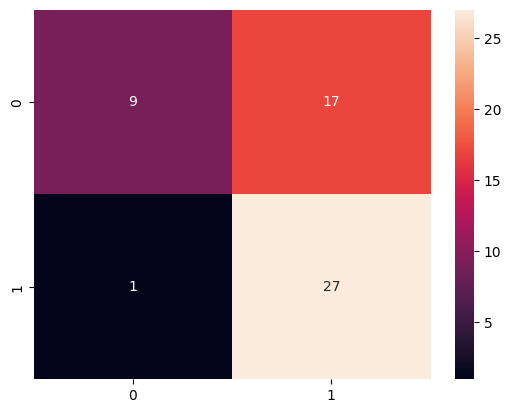

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(originais, previsoes)
sns.heatmap(cm, annot=True)


In [21]:
print(classification_report(originais, previsoes))

              precision    recall  f1-score   support

           0       0.90      0.35      0.50        26
           1       0.61      0.96      0.75        28

    accuracy                           0.67        54
   macro avg       0.76      0.66      0.62        54
weighted avg       0.75      0.67      0.63        54



### Classificando uma unica imagem


In [30]:
int_index = 7

img_to_predict = test_ds.take(int_index + 1)
img_to_classify = None
label_to_classify = None
for img, predict_label in img_to_predict:
    img_to_classify = img[int_index]
    label_to_classify = predict_label[int_index]

img_to_classify = tf.expand_dims(img_to_classify, axis=0)  #adiciona dimensão de batch
prediction = model.predict(img_to_classify)
prediction = np.argmax(prediction, axis=1)
#prediction
label = np.argmax(label_to_classify.numpy(), axis=0)
label, int(prediction.astype(int))


#print(f"Retorno: {prediction, } ")








1/1 [==============================] - 0s 18ms/step


(0, 0)